In [141]:
import torch
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, Trainer
import re
import string
import matplotlib.pyplot as plt

In [2]:
model = AutoModelForQuestionAnswering.from_pretrained('./models/test_all_model')
tokenizer = AutoTokenizer.from_pretrained('./models/test_all_model')


In [ ]:
device = torch.device("mps")
model.to(device)

In [13]:
from datasets import load_dataset
squad_dataset = load_dataset('squad')

In [133]:
print(len(squad_dataset['train']))
print(len(squad_dataset['validation']))

87599
10570


In [134]:
# some cleaning
def remove_duplicates(dataset):
    seen = set()
    unique_dataset = []

    for example in dataset:
        question = example["question"].lower()
        answers = tuple(answer.lower() for answer in example["answers"]["text"])
        if (question, answers) not in seen:
            seen.add((question, answers))
            unique_dataset.append(example)

    return unique_dataset

In [135]:
squad_dataset['validation'] = remove_duplicates(squad_dataset['validation'])

In [136]:
# Removed 18
print(len(squad_dataset['validation']))

10552


In [97]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_apostrophe_space(text):
        return text.replace(" ' ", "'")
    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(remove_apostrophe_space(lower(s)))))

In [17]:
def compute_exact(answer, prediction):
    return int(normalize_answer(answer) == normalize_answer(prediction))

In [139]:
def evaluate_model(model, eval_dataset, tokenizer):
    exact_match = 0
    no_answer_indices = []
    failed_predictions = []
    total_count = len(eval_dataset)

    for idex, example in enumerate(eval_dataset):        # Tokenize the input question and context
        inputs = tokenizer(
            example["question"], example["context"],
            return_tensors="pt", truncation=True, max_length=512
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            start_logits = outputs.start_logits.squeeze()
            end_logits = outputs.end_logits.squeeze()

        start_indices = torch.argsort(start_logits, descending=True)
        end_indices = torch.argsort(end_logits, descending=True)
        valid_answer_found = False
        idx = 0

        while not valid_answer_found and idx < len(start_indices):
            start_index = start_indices[idx].item()
            end_index = end_indices[idx].item() + 1

            # Check if the answer is valid (start is before end and not empty)
            if start_index < end_index and end_index <= inputs["input_ids"].size(1):
                valid_answer_found = True
                predicted_answer = tokenizer.decode(inputs["input_ids"][0][start_index:end_index]).lower()
            else:
                idx += 1

        if not valid_answer_found:
            predicted_answer = ""
        # our predictions have a space around the apostrophe, so we need to remove it for example answer levi ' s stadium which is correct has incorrect apostrophe handling
        correct_answers = [answer.lower() for answer in example["answers"]["text"]]

        if any(compute_exact(answer, predicted_answer) or (answer in predicted_answer) for answer in correct_answers):
            exact_match += 1
        else:
            failed_predictions.append(idex)
        
        if predicted_answer.strip() == "":
            no_answer_indices.append(idex)

    exact_match_score = 100.0 * exact_match / total_count
    print(f"Exact Match: {exact_match_score:.2f}%")
    print(f"No Answer Predictions at Indices: {no_answer_indices}")
    print(f"Failed Predictions at Indices: {failed_predictions}")


In [15]:
evaluate_model(model, squad_dataset['validation'], tokenizer)

Correct Answers: 7235/10570
Accuracy: 0.68


In [26]:
evaluate_model(model, squad_dataset['validation'], tokenizer)

Exact Match: 72.41%
F1 Score: 81.63%


In [80]:
# Searching for next answer if answer is empty
evaluate_model(model, squad_dataset['validation'], tokenizer)

Exact Match: 72.56%
F1 Score: 82.18%


In [102]:
# Better handling of apostrophes
evaluate_model(model, squad_dataset['validation'], tokenizer)

Exact Match: 73.63%
No Answer Predictions at Indices: []
Failed Predictions at Indices: [4, 5, 8, 13, 17, 19, 28, 40, 42, 47, 48, 50, 62, 73, 84, 87, 88, 101, 114, 117, 123, 125, 129, 132, 133, 147, 158, 162, 167, 173, 176, 182, 190, 191, 222, 223, 224, 228, 229, 232, 233, 234, 245, 248, 253, 259, 264, 265, 270, 271, 272, 275, 276, 280, 284, 288, 289, 292, 298, 306, 307, 308, 309, 310, 315, 321, 323, 324, 338, 341, 354, 358, 366, 367, 374, 377, 382, 385, 396, 402, 403, 407, 427, 439, 440, 443, 444, 446, 447, 466, 481, 491, 495, 507, 508, 509, 518, 521, 523, 524, 526, 530, 540, 543, 550, 564, 565, 566, 567, 569, 570, 571, 574, 578, 579, 581, 582, 583, 584, 587, 588, 590, 592, 594, 599, 601, 606, 616, 618, 632, 643, 644, 648, 658, 666, 674, 680, 683, 686, 688, 699, 706, 714, 716, 722, 726, 730, 735, 742, 743, 760, 765, 767, 769, 775, 776, 780, 785, 793, 794, 796, 797, 802, 805, 812, 823, 826, 831, 839, 841, 846, 848, 853, 855, 856, 861, 886, 889, 891, 893, 908, 916, 921, 931, 932, 948, 9

In [138]:
# Noticed a few cases where validation set had duplicates. removed with remove_duplicates. See squad_dataset['validation'] indexes 13 & 17.
evaluate_model(model, squad_dataset['validation'], tokenizer)

Exact Match: 73.61%
No Answer Predictions at Indices: []
Failed Predictions at Indices: [4, 5, 8, 13, 18, 26, 38, 40, 45, 46, 48, 60, 71, 82, 85, 86, 99, 112, 115, 121, 123, 127, 130, 131, 145, 156, 164, 170, 173, 179, 187, 188, 219, 220, 221, 225, 226, 229, 230, 231, 242, 245, 250, 256, 261, 262, 267, 268, 269, 272, 273, 277, 281, 285, 286, 289, 295, 303, 304, 305, 306, 307, 312, 318, 320, 321, 334, 336, 349, 353, 361, 362, 368, 371, 376, 379, 390, 396, 397, 401, 421, 432, 433, 436, 437, 439, 440, 459, 473, 483, 487, 499, 500, 501, 510, 513, 515, 516, 518, 522, 532, 535, 542, 556, 557, 558, 559, 561, 562, 563, 566, 570, 571, 573, 574, 575, 576, 579, 580, 582, 584, 586, 591, 593, 598, 608, 610, 624, 635, 636, 640, 650, 658, 666, 672, 675, 678, 680, 691, 698, 706, 708, 714, 718, 722, 727, 734, 735, 752, 757, 759, 761, 767, 768, 772, 777, 785, 786, 788, 789, 794, 797, 804, 815, 818, 823, 831, 833, 838, 840, 845, 847, 848, 853, 878, 881, 883, 885, 900, 908, 913, 923, 924, 940, 947, 954, 9

In [140]:
# added check to qualify predicton if predicted answer contains answer. E.g. answer = 'Santa Clara', predicted = 'Santa Clara, California'
evaluate_model(model, squad_dataset['validation'], tokenizer)

Exact Match: 82.31%
No Answer Predictions at Indices: []
Failed Predictions at Indices: [5, 8, 18, 38, 40, 45, 46, 48, 115, 121, 123, 127, 130, 131, 145, 156, 164, 173, 179, 187, 188, 219, 221, 225, 226, 229, 230, 231, 242, 245, 250, 262, 267, 268, 272, 273, 277, 281, 285, 286, 289, 295, 303, 304, 305, 306, 307, 312, 318, 320, 321, 349, 353, 361, 362, 368, 371, 379, 390, 396, 397, 401, 421, 439, 459, 473, 483, 499, 501, 510, 513, 515, 542, 559, 571, 573, 575, 576, 579, 580, 584, 586, 591, 593, 598, 635, 636, 650, 658, 666, 672, 675, 678, 691, 698, 708, 714, 718, 722, 727, 734, 735, 757, 761, 767, 768, 777, 785, 797, 804, 815, 818, 823, 831, 833, 838, 847, 853, 878, 881, 923, 940, 947, 954, 970, 977, 980, 982, 1001, 1002, 1006, 1007, 1008, 1009, 1021, 1025, 1028, 1033, 1042, 1047, 1056, 1077, 1083, 1084, 1086, 1087, 1104, 1105, 1128, 1132, 1140, 1146, 1179, 1180, 1202, 1203, 1208, 1230, 1244, 1245, 1270, 1271, 1272, 1275, 1276, 1290, 1296, 1297, 1300, 1301, 1305, 1311, 1315, 1324, 1325,

In [163]:
def rerun_single_prediction(model, eval_dataset, tokenizer, index):
    """ used to evaluate a single prediction, and improve my evaluation function """
    example = eval_dataset[index]

    inputs = tokenizer(
        example["question"], example["context"],
        return_tensors="pt", truncation=True, max_length=512
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        start_logits = outputs.start_logits.squeeze()
        end_logits = outputs.end_logits.squeeze()

    start_indices = torch.argsort(start_logits, descending=True)
    end_indices = torch.argsort(end_logits, descending=True)
    valid_answer_found = False
    idx = 0

    while not valid_answer_found and idx < len(start_indices):
        start_index = start_indices[idx].item()
        end_index = end_indices[idx].item() + 1

        if start_index < end_index and end_index <= inputs["input_ids"].size(1):
            valid_answer_found = True
            predicted_answer = tokenizer.decode(inputs["input_ids"][0][start_index:end_index]).lower()
        else:
            idx += 1

    if not valid_answer_found:
        predicted_answer = ""

    
    print(f"Pre-normalize Predicted Answer: {predicted_answer}")
    correct_answers = [answer.lower() for answer in example["answers"]["text"]]
    print(f"Pre-normalize Correct Answers: {correct_answers}")

    predicted_answer = normalize_answer(predicted_answer)
    correct_answers = [normalize_answer(answer) for answer in correct_answers]

    print(f"Post-normalize Predicted Answer: {predicted_answer}")
    print(f"Post-normalize Correct Answers: {correct_answers}")

    print(f"Question: {example['question']}")
    print(f"Context: {example['context']}")



In [147]:
failed_predictions_strict = [4, 5, 8, 13, 18, 26, 38, 40, 45, 46, 48, 60, 71, 82, 85, 86, 99, 112, 115, 121, 123, 127, 130, 131, 145, 156, 164, 170, 173, 179, 187, 188, 219, 220, 221, 225, 226, 229, 230, 231, 242, 245, 250, 256, 261, 262, 267, 268, 269, 272, 273, 277, 281, 285, 286, 289, 295, 303, 304, 305, 306, 307, 312, 318, 320, 321, 334, 336, 349, 353, 361, 362, 368, 371, 376, 379, 390, 396, 397, 401, 421, 432, 433, 436, 437, 439, 440, 459, 473, 483, 487, 499, 500, 501, 510, 513, 515, 516, 518, 522, 532, 535, 542, 556, 557, 558, 559, 561, 562, 563, 566, 570, 571, 573, 574, 575, 576, 579, 580, 582, 584, 586, 591, 593, 598, 608, 610, 624, 635, 636, 640, 650, 658, 666, 672, 675, 678, 680, 691, 698, 706, 708, 714, 718, 722, 727, 734, 735, 752, 757, 759, 761, 767, 768, 772, 777, 785, 786, 788, 789, 794, 797, 804, 815, 818, 823, 831, 833, 838, 840, 845, 847, 848, 853, 878, 881, 883, 885, 900, 908, 913, 923, 924, 940, 947, 954, 961, 965, 970, 973, 977, 978, 980, 982, 991, 996, 1001, 1002, 1004, 1006, 1007, 1008, 1009, 1010, 1021, 1025, 1028, 1031, 1033, 1035, 1038, 1042, 1046, 1047, 1056, 1060, 1061, 1063, 1077, 1083, 1084, 1086, 1087, 1094, 1095, 1102, 1104, 1105, 1107, 1108, 1109, 1128, 1129, 1132, 1139, 1140, 1144, 1146, 1177, 1179, 1180, 1183, 1191, 1197, 1202, 1203, 1208, 1217, 1223, 1230, 1236, 1243, 1244, 1245, 1248, 1257, 1270, 1271, 1272, 1274, 1275, 1276, 1290, 1293, 1296, 1297, 1300, 1301, 1305, 1306, 1311, 1315, 1316, 1324, 1325, 1332, 1334, 1336, 1337, 1343, 1348, 1351, 1353, 1359, 1362, 1365, 1378, 1383, 1386, 1387, 1389, 1390, 1391, 1393, 1394, 1410, 1414, 1416, 1418, 1421, 1425, 1426, 1427, 1428, 1429, 1430, 1433, 1450, 1471, 1476, 1478, 1479, 1480, 1485, 1486, 1487, 1488, 1490, 1491, 1492, 1493, 1494, 1497, 1499, 1502, 1504, 1505, 1510, 1511, 1512, 1515, 1520, 1524, 1526, 1527, 1528, 1531, 1547, 1550, 1553, 1557, 1564, 1567, 1569, 1579, 1580, 1581, 1585, 1586, 1587, 1589, 1590, 1591, 1592, 1597, 1598, 1600, 1606, 1608, 1620, 1624, 1628, 1629, 1630, 1631, 1634, 1637, 1641, 1642, 1645, 1648, 1653, 1658, 1660, 1663, 1665, 1668, 1675, 1679, 1681, 1687, 1690, 1691, 1692, 1698, 1699, 1704, 1710, 1712, 1719, 1720, 1729, 1732, 1733, 1738, 1741, 1742, 1744, 1745, 1749, 1752, 1756, 1757, 1759, 1765, 1768, 1771, 1772, 1773, 1777, 1784, 1794, 1795, 1796, 1797, 1798, 1799, 1802, 1804, 1805, 1807, 1808, 1810, 1811, 1812, 1816, 1818, 1821, 1822, 1829, 1830, 1832, 1833, 1835, 1838, 1843, 1844, 1847, 1848, 1849, 1850, 1854, 1864, 1866, 1873, 1874, 1879, 1881, 1883, 1894, 1899, 1901, 1902, 1908, 1910, 1912, 1913, 1915, 1918, 1921, 1923, 1924, 1932, 1933, 1935, 1942, 1943, 1946, 1960, 1961, 1964, 1968, 1979, 1981, 1984, 1985, 1988, 1990, 1993, 1995, 1999, 2001, 2008, 2014, 2019, 2020, 2030, 2041, 2046, 2051, 2052, 2053, 2054, 2060, 2061, 2063, 2064, 2065, 2071, 2074, 2076, 2080, 2082, 2090, 2091, 2103, 2105, 2109, 2111, 2113, 2114, 2115, 2116, 2117, 2119, 2128, 2133, 2135, 2140, 2141, 2142, 2160, 2162, 2169, 2188, 2190, 2194, 2198, 2204, 2207, 2210, 2213, 2217, 2222, 2227, 2245, 2247, 2248, 2252, 2255, 2268, 2270, 2272, 2275, 2276, 2283, 2285, 2286, 2288, 2290, 2295, 2296, 2299, 2321, 2323, 2324, 2325, 2330, 2337, 2352, 2357, 2360, 2362, 2364, 2371, 2373, 2377, 2385, 2394, 2395, 2396, 2403, 2405, 2407, 2412, 2417, 2421, 2423, 2433, 2434, 2442, 2448, 2449, 2451, 2456, 2459, 2460, 2463, 2464, 2473, 2475, 2477, 2485, 2488, 2493, 2496, 2497, 2498, 2500, 2508, 2509, 2512, 2518, 2519, 2523, 2524, 2526, 2527, 2536, 2538, 2542, 2545, 2548, 2552, 2555, 2558, 2559, 2562, 2567, 2568, 2571, 2572, 2573, 2574, 2576, 2579, 2585, 2587, 2592, 2595, 2597, 2599, 2603, 2607, 2608, 2609, 2611, 2612, 2614, 2615, 2620, 2623, 2624, 2625, 2626, 2629, 2630, 2634, 2635, 2636, 2642, 2643, 2644, 2654, 2656, 2659, 2667, 2671, 2681, 2682, 2683, 2688, 2696, 2698, 2700, 2703, 2704, 2705, 2706, 2710, 2713, 2719, 2720, 2721, 2726, 2727, 2728, 2729, 2730, 2742, 2744, 2745, 2750, 2751, 2754, 2767, 2769, 2788, 2789, 2791, 2792, 2804, 2806, 2814, 2818, 2823, 2827, 2834, 2841, 2844, 2846, 2848, 2853, 2855, 2857, 2858, 2861, 2864, 2867, 2875, 2877, 2878, 2881, 2883, 2896, 2912, 2914, 2918, 2924, 2925, 2927, 2928, 2929, 2930, 2931, 2933, 2936, 2939, 2941, 2943, 2947, 2949, 2951, 2952, 2958, 2959, 2960, 2961, 2963, 2964, 2966, 2969, 2971, 2972, 2973, 2974, 2975, 2978, 2986, 2987, 2988, 2989, 2991, 2992, 2993, 2997, 2999, 3000, 3001, 3013, 3017, 3018, 3020, 3021, 3023, 3029, 3038, 3045, 3047, 3055, 3056, 3058, 3070, 3071, 3074, 3076, 3077, 3079, 3086, 3088, 3091, 3093, 3097, 3099, 3102, 3104, 3106, 3112, 3113, 3114, 3115, 3116, 3121, 3126, 3134, 3141, 3143, 3146, 3147, 3148, 3150, 3158, 3159, 3161, 3170, 3177, 3179, 3186, 3187, 3190, 3198, 3199, 3207, 3209, 3211, 3212, 3216, 3219, 3220, 3222, 3236, 3257, 3261, 3264, 3266, 3300, 3317, 3318, 3323, 3325, 3338, 3355, 3356, 3357, 3361, 3363, 3370, 3377, 3378, 3382, 3388, 3420, 3423, 3425, 3436, 3448, 3451, 3453, 3454, 3455, 3456, 3459, 3461, 3465, 3466, 3468, 3469, 3477, 3481, 3494, 3499, 3500, 3504, 3511, 3512, 3514, 3515, 3519, 3520, 3522, 3524, 3525, 3527, 3534, 3541, 3542, 3545, 3548, 3560, 3561, 3562, 3566, 3571, 3572, 3581, 3582, 3584, 3586, 3589, 3591, 3594, 3595, 3605, 3607, 3608, 3611, 3619, 3623, 3624, 3625, 3626, 3629, 3634, 3637, 3638, 3644, 3647, 3648, 3652, 3654, 3655, 3656, 3669, 3670, 3671, 3674, 3677, 3681, 3683, 3686, 3687, 3692, 3699, 3701, 3703, 3704, 3706, 3708, 3713, 3718, 3720, 3723, 3729, 3730, 3732, 3733, 3734, 3736, 3738, 3743, 3756, 3757, 3761, 3775, 3781, 3786, 3789, 3791, 3793, 3794, 3795, 3796, 3797, 3798, 3804, 3814, 3816, 3817, 3818, 3823, 3842, 3861, 3864, 3873, 3882, 3896, 3899, 3902, 3904, 3906, 3909, 3913, 3914, 3924, 3926, 3927, 3930, 3931, 3932, 3935, 3939, 3942, 3943, 3945, 3946, 3948, 3951, 3953, 3954, 3957, 3958, 3963, 3969, 3970, 3971, 3973, 3975, 3976, 3978, 3980, 3981, 3982, 3984, 3985, 3991, 3992, 3996, 4000, 4003, 4005, 4006, 4014, 4019, 4022, 4025, 4030, 4035, 4036, 4043, 4048, 4058, 4060, 4071, 4075, 4085, 4086, 4087, 4088, 4097, 4105, 4108, 4109, 4110, 4118, 4120, 4124, 4127, 4131, 4134, 4136, 4142, 4144, 4151, 4152, 4157, 4158, 4161, 4162, 4172, 4173, 4180, 4181, 4184, 4191, 4192, 4195, 4197, 4198, 4201, 4209, 4211, 4223, 4242, 4249, 4255, 4259, 4260, 4264, 4265, 4270, 4271, 4273, 4274, 4280, 4281, 4282, 4283, 4290, 4291, 4293, 4294, 4298, 4306, 4308, 4311, 4316, 4321, 4322, 4323, 4325, 4327, 4330, 4331, 4332, 4333, 4337, 4338, 4344, 4345, 4347, 4351, 4358, 4361, 4363, 4369, 4370, 4372, 4378, 4382, 4384, 4387, 4388, 4389, 4392, 4394, 4396, 4399, 4405, 4407, 4408, 4409, 4410, 4411, 4412, 4416, 4417, 4419, 4421, 4422, 4424, 4435, 4436, 4437, 4438, 4442, 4443, 4447, 4449, 4453, 4454, 4456, 4459, 4463, 4466, 4476, 4479, 4482, 4483, 4484, 4486, 4488, 4490, 4493, 4495, 4501, 4503, 4504, 4507, 4508, 4520, 4523, 4525, 4528, 4529, 4532, 4533, 4534, 4535, 4555, 4559, 4560, 4563, 4565, 4566, 4567, 4572, 4573, 4581, 4585, 4590, 4596, 4599, 4601, 4605, 4606, 4610, 4612, 4613, 4614, 4623, 4629, 4630, 4633, 4634, 4636, 4638, 4642, 4645, 4647, 4650, 4651, 4654, 4659, 4662, 4665, 4667, 4670, 4671, 4689, 4691, 4692, 4697, 4700, 4702, 4703, 4709, 4718, 4731, 4732, 4733, 4746, 4751, 4753, 4756, 4761, 4762, 4763, 4764, 4765, 4766, 4767, 4768, 4769, 4770, 4771, 4772, 4773, 4774, 4775, 4776, 4778, 4779, 4780, 4786, 4790, 4797, 4798, 4799, 4800, 4801, 4802, 4803, 4808, 4809, 4812, 4814, 4817, 4818, 4819, 4820, 4823, 4824, 4826, 4830, 4834, 4837, 4839, 4840, 4841, 4842, 4845, 4846, 4847, 4850, 4852, 4853, 4854, 4855, 4856, 4858, 4859, 4860, 4861, 4862, 4863, 4864, 4865, 4866, 4868, 4872, 4873, 4875, 4878, 4879, 4880, 4881, 4883, 4885, 4886, 4888, 4889, 4894, 4895, 4896, 4897, 4898, 4900, 4901, 4903, 4904, 4906, 4907, 4908, 4916, 4917, 4918, 4919, 4924, 4926, 4928, 4930, 4931, 4933, 4935, 4943, 4945, 4946, 4949, 4951, 4952, 4954, 4958, 4960, 4961, 4962, 4965, 4974, 4980, 4982, 4986, 4989, 4991, 4992, 4993, 4994, 4996, 4998, 5001, 5002, 5004, 5008, 5009, 5022, 5026, 5029, 5030, 5033, 5034, 5046, 5050, 5059, 5066, 5068, 5073, 5081, 5082, 5086, 5090, 5091, 5102, 5103, 5108, 5111, 5126, 5127, 5128, 5138, 5143, 5150, 5153, 5154, 5170, 5172, 5178, 5181, 5184, 5198, 5215, 5216, 5217, 5218, 5221, 5225, 5226, 5228, 5231, 5233, 5234, 5235, 5242, 5243, 5244, 5246, 5266, 5267, 5273, 5276, 5280, 5286, 5290, 5297, 5299, 5303, 5315, 5322, 5324, 5333, 5339, 5346, 5347, 5368, 5371, 5382, 5390, 5391, 5394, 5399, 5401, 5403, 5422, 5430, 5431, 5436, 5437, 5439, 5451, 5457, 5468, 5472, 5480, 5482, 5484, 5485, 5486, 5487, 5493, 5498, 5499, 5503, 5508, 5514, 5516, 5520, 5521, 5523, 5524, 5526, 5531, 5536, 5543, 5544, 5564, 5567, 5573, 5574, 5575, 5576, 5577, 5578, 5586, 5590, 5592, 5597, 5598, 5604, 5607, 5613, 5621, 5625, 5628, 5637, 5638, 5640, 5643, 5644, 5645, 5651, 5652, 5653, 5654, 5660, 5662, 5670, 5673, 5677, 5682, 5683, 5685, 5698, 5700, 5703, 5714, 5718, 5727, 5733, 5737, 5738, 5743, 5747, 5756, 5760, 5767, 5777, 5791, 5793, 5798, 5799, 5800, 5805, 5809, 5814, 5823, 5824, 5837, 5845, 5855, 5865, 5867, 5872, 5882, 5885, 5886, 5894, 5906, 5915, 5923, 5926, 5927, 5929, 5930, 5943, 5945, 5950, 5953, 5957, 5967, 5971, 5974, 5975, 5979, 5983, 5987, 5995, 5996, 5998, 5999, 6000, 6007, 6022, 6023, 6026, 6027, 6028, 6034, 6035, 6043, 6048, 6053, 6056, 6059, 6062, 6076, 6080, 6082, 6087, 6088, 6089, 6095, 6096, 6099, 6105, 6107, 6113, 6116, 6117, 6126, 6128, 6130, 6132, 6133, 6136, 6137, 6147, 6152, 6160, 6164, 6170, 6171, 6172, 6177, 6178, 6181, 6183, 6184, 6186, 6189, 6193, 6196, 6197, 6199, 6203, 6204, 6205, 6215, 6216, 6217, 6219, 6221, 6224, 6233, 6234, 6237, 6244, 6246, 6256, 6260, 6270, 6275, 6283, 6285, 6287, 6289, 6300, 6302, 6308, 6317, 6325, 6330, 6333, 6338, 6340, 6344, 6345, 6348, 6350, 6351, 6352, 6358, 6359, 6364, 6365, 6366, 6367, 6373, 6375, 6376, 6378, 6379, 6380, 6382, 6384, 6385, 6386, 6391, 6404, 6406, 6408, 6410, 6411, 6416, 6417, 6424, 6431, 6432, 6434, 6435, 6437, 6438, 6441, 6443, 6444, 6446, 6447, 6448, 6449, 6450, 6453, 6460, 6467, 6471, 6475, 6477, 6478, 6479, 6480, 6483, 6490, 6491, 6492, 6496, 6497, 6506, 6510, 6512, 6514, 6520, 6525, 6526, 6533, 6551, 6561, 6564, 6572, 6576, 6577, 6584, 6588, 6590, 6594, 6597, 6603, 6605, 6607, 6612, 6617, 6622, 6630, 6638, 6652, 6666, 6669, 6675, 6683, 6686, 6689, 6694, 6697, 6704, 6720, 6721, 6722, 6731, 6732, 6733, 6736, 6740, 6743, 6746, 6751, 6752, 6753, 6758, 6760, 6761, 6764, 6768, 6769, 6774, 6777, 6779, 6783, 6788, 6790, 6794, 6795, 6796, 6798, 6804, 6805, 6807, 6810, 6814, 6815, 6818, 6824, 6825, 6829, 6831, 6835, 6837, 6838, 6839, 6840, 6843, 6846, 6848, 6849, 6851, 6852, 6854, 6856, 6859, 6860, 6861, 6863, 6864, 6867, 6868, 6869, 6870, 6871, 6872, 6878, 6879, 6880, 6882, 6883, 6885, 6886, 6887, 6888, 6889, 6890, 6892, 6894, 6895, 6897, 6899, 6903, 6911, 6912, 6916, 6920, 6926, 6935, 6936, 6942, 6943, 6945, 6947, 6959, 6968, 6969, 6970, 6977, 6988, 6990, 6991, 6992, 6993, 6996, 6999, 7000, 7001, 7002, 7003, 7013, 7015, 7021, 7022, 7023, 7024, 7025, 7027, 7031, 7043, 7044, 7046, 7048, 7050, 7051, 7052, 7056, 7058, 7059, 7067, 7072, 7075, 7080, 7082, 7084, 7087, 7089, 7092, 7095, 7097, 7098, 7099, 7105, 7106, 7107, 7108, 7121, 7122, 7127, 7133, 7144, 7146, 7157, 7158, 7159, 7160, 7161, 7165, 7167, 7170, 7172, 7174, 7178, 7179, 7181, 7183, 7184, 7185, 7193, 7201, 7212, 7220, 7224, 7239, 7244, 7248, 7250, 7260, 7263, 7266, 7271, 7279, 7282, 7287, 7288, 7291, 7293, 7295, 7303, 7307, 7309, 7312, 7315, 7316, 7317, 7318, 7320, 7321, 7322, 7323, 7325, 7328, 7332, 7338, 7339, 7340, 7341, 7342, 7346, 7347, 7348, 7349, 7351, 7354, 7359, 7369, 7371, 7375, 7378, 7379, 7380, 7381, 7384, 7385, 7393, 7395, 7396, 7397, 7399, 7400, 7404, 7407, 7410, 7413, 7414, 7415, 7416, 7417, 7419, 7421, 7423, 7427, 7439, 7443, 7444, 7445, 7446, 7447, 7453, 7460, 7461, 7462, 7463, 7470, 7471, 7472, 7476, 7479, 7482, 7483, 7491, 7500, 7501, 7506, 7508, 7511, 7520, 7524, 7527, 7532, 7534, 7536, 7539, 7544, 7546, 7547, 7549, 7563, 7566, 7574, 7579, 7584, 7587, 7592, 7593, 7594, 7595, 7596, 7599, 7608, 7609, 7611, 7620, 7623, 7624, 7635, 7636, 7642, 7643, 7649, 7654, 7661, 7662, 7663, 7665, 7670, 7671, 7672, 7683, 7697, 7699, 7706, 7714, 7717, 7718, 7720, 7731, 7733, 7744, 7751, 7753, 7757, 7758, 7768, 7770, 7772, 7776, 7784, 7787, 7799, 7800, 7803, 7805, 7807, 7812, 7813, 7817, 7818, 7819, 7820, 7822, 7824, 7825, 7826, 7827, 7829, 7836, 7840, 7844, 7853, 7855, 7859, 7863, 7868, 7875, 7878, 7881, 7887, 7889, 7894, 7897, 7906, 7914, 7918, 7919, 7922, 7939, 7940, 7950, 7953, 7955, 7957, 7958, 7963, 7966, 7971, 7975, 7982, 7988, 8003, 8009, 8014, 8015, 8017, 8020, 8027, 8028, 8035, 8036, 8037, 8038, 8041, 8044, 8045, 8049, 8051, 8062, 8067, 8070, 8080, 8090, 8098, 8100, 8117, 8121, 8123, 8125, 8128, 8131, 8132, 8133, 8137, 8139, 8163, 8166, 8169, 8178, 8186, 8190, 8200, 8204, 8211, 8219, 8220, 8221, 8223, 8229, 8233, 8235, 8239, 8241, 8242, 8247, 8248, 8252, 8255, 8260, 8279, 8281, 8283, 8285, 8288, 8295, 8296, 8307, 8309, 8315, 8316, 8322, 8326, 8327, 8328, 8330, 8331, 8332, 8333, 8339, 8343, 8347, 8351, 8358, 8363, 8365, 8369, 8379, 8384, 8385, 8387, 8389, 8394, 8396, 8403, 8404, 8405, 8407, 8410, 8414, 8420, 8421, 8422, 8425, 8426, 8428, 8432, 8435, 8436, 8443, 8444, 8447, 8449, 8450, 8464, 8466, 8467, 8468, 8471, 8477, 8478, 8480, 8481, 8489, 8490, 8492, 8495, 8499, 8501, 8506, 8509, 8510, 8512, 8515, 8516, 8519, 8523, 8525, 8526, 8527, 8528, 8529, 8533, 8535, 8536, 8538, 8542, 8545, 8550, 8554, 8555, 8564, 8567, 8569, 8574, 8578, 8582, 8583, 8586, 8588, 8589, 8591, 8592, 8594, 8595, 8601, 8602, 8607, 8609, 8611, 8613, 8619, 8620, 8622, 8624, 8626, 8627, 8629, 8631, 8636, 8639, 8644, 8650, 8651, 8652, 8654, 8655, 8657, 8659, 8661, 8664, 8671, 8672, 8675, 8676, 8683, 8690, 8693, 8695, 8696, 8704, 8707, 8713, 8714, 8715, 8716, 8721, 8722, 8724, 8730, 8732, 8739, 8740, 8744, 8745, 8746, 8753, 8754, 8755, 8757, 8759, 8766, 8767, 8772, 8785, 8788, 8791, 8796, 8801, 8802, 8803, 8805, 8806, 8807, 8808, 8810, 8819, 8820, 8823, 8825, 8828, 8829, 8830, 8832, 8835, 8841, 8843, 8845, 8849, 8854, 8859, 8860, 8863, 8864, 8865, 8866, 8868, 8870, 8871, 8872, 8873, 8879, 8880, 8881, 8882, 8888, 8891, 8892, 8894, 8898, 8907, 8909, 8912, 8913, 8917, 8919, 8920, 8921, 8927, 8930, 8932, 8935, 8940, 8943, 8944, 8946, 8947, 8948, 8953, 8956, 8959, 8960, 8963, 8964, 8967, 8968, 8969, 8976, 8977, 8978, 8979, 8987, 8988, 8997, 8998, 8999, 9002, 9011, 9013, 9020, 9021, 9023, 9026, 9027, 9028, 9029, 9031, 9033, 9034, 9036, 9038, 9041, 9042, 9044, 9046, 9047, 9053, 9057, 9058, 9064, 9068, 9080, 9083, 9090, 9095, 9096, 9098, 9103, 9106, 9114, 9116, 9119, 9122, 9126, 9127, 9129, 9138, 9139, 9141, 9144, 9146, 9147, 9152, 9158, 9174, 9182, 9187, 9188, 9191, 9192, 9201, 9206, 9212, 9229, 9230, 9233, 9238, 9267, 9272, 9295, 9297, 9299, 9300, 9307, 9309, 9311, 9316, 9321, 9323, 9326, 9329, 9332, 9334, 9335, 9336, 9338, 9339, 9342, 9343, 9345, 9348, 9351, 9354, 9355, 9356, 9357, 9360, 9362, 9363, 9365, 9366, 9377, 9379, 9384, 9396, 9404, 9408, 9411, 9412, 9413, 9415, 9419, 9430, 9432, 9437, 9440, 9443, 9446, 9471, 9482, 9493, 9495, 9497, 9500, 9503, 9504, 9506, 9514, 9515, 9516, 9517, 9526, 9527, 9532, 9538, 9539, 9545, 9547, 9550, 9552, 9553, 9554, 9561, 9565, 9572, 9576, 9597, 9602, 9609, 9613, 9619, 9622, 9624, 9626, 9630, 9631, 9636, 9637, 9641, 9644, 9649, 9668, 9682, 9689, 9692, 9694, 9696, 9698, 9702, 9704, 9705, 9707, 9711, 9722, 9723, 9724, 9725, 9726, 9732, 9741, 9749, 9750, 9758, 9763, 9764, 9770, 9771, 9779, 9784, 9786, 9787, 9790, 9798, 9801, 9808, 9809, 9811, 9826, 9828, 9830, 9836, 9837, 9843, 9846, 9850, 9852, 9853, 9856, 9857, 9858, 9860, 9862, 9863, 9869, 9879, 9895, 9901, 9902, 9909, 9915, 9918, 9920, 9922, 9924, 9933, 9937, 9938, 9945, 9946, 9950, 9961, 9962, 9964, 9966, 9971, 9972, 9981, 9990, 9995, 9996, 9998, 10000, 10021, 10025, 10035, 10042, 10045, 10051, 10058, 10059, 10064, 10065, 10067, 10072, 10075, 10077, 10082, 10088, 10104, 10110, 10114, 10115, 10121, 10122, 10127, 10133, 10137, 10139, 10144, 10156, 10158, 10160, 10168, 10170, 10172, 10173, 10174, 10178, 10180, 10182, 10183, 10189, 10191, 10194, 10195, 10196, 10201, 10205, 10206, 10209, 10213, 10214, 10220, 10221, 10222, 10223, 10224, 10228, 10229, 10230, 10235, 10239, 10243, 10245, 10249, 10257, 10260, 10264, 10265, 10267, 10270, 10273, 10274, 10277, 10280, 10281, 10282, 10285, 10289, 10293, 10294, 10296, 10299, 10300, 10305, 10313, 10320, 10321, 10322, 10323, 10329, 10332, 10333, 10337, 10338, 10346, 10348, 10352, 10357, 10358, 10374, 10387, 10388, 10392, 10404, 10409, 10414, 10417, 10428, 10434, 10441, 10443, 10456, 10459, 10463, 10476, 10482, 10488, 10499, 10503, 10504, 10513, 10515, 10517, 10518, 10521, 10524, 10525, 10530, 10534, 10547, 10551]
failed_predictions = [5, 8, 18, 38, 40, 45, 46, 48, 115, 121, 123, 127, 130, 131, 145, 156, 164, 173, 179, 187, 188, 219, 221, 225, 226, 229, 230, 231, 242, 245, 250, 262, 267, 268, 272, 273, 277, 281, 285, 286, 289, 295, 303, 304, 305, 306, 307, 312, 318, 320, 321, 349, 353, 361, 362, 368, 371, 379, 390, 396, 397, 401, 421, 439, 459, 473, 483, 499, 501, 510, 513, 515, 542, 559, 571, 573, 575, 576, 579, 580, 584, 586, 591, 593, 598, 635, 636, 650, 658, 666, 672, 675, 678, 691, 698, 708, 714, 718, 722, 727, 734, 735, 757, 761, 767, 768, 777, 785, 797, 804, 815, 818, 823, 831, 833, 838, 847, 853, 878, 881, 923, 940, 947, 954, 970, 977, 980, 982, 1001, 1002, 1006, 1007, 1008, 1009, 1021, 1025, 1028, 1033, 1042, 1047, 1056, 1077, 1083, 1084, 1086, 1087, 1104, 1105, 1128, 1132, 1140, 1146, 1179, 1180, 1202, 1203, 1208, 1230, 1244, 1245, 1270, 1271, 1272, 1275, 1276, 1290, 1296, 1297, 1300, 1301, 1305, 1311, 1315, 1324, 1325, 1332, 1334, 1337, 1348, 1351, 1353, 1359, 1378, 1383, 1386, 1389, 1390, 1391, 1393, 1394, 1414, 1416, 1418, 1421, 1425, 1426, 1427, 1428, 1429, 1430, 1433, 1476, 1478, 1479, 1480, 1487, 1490, 1492, 1494, 1497, 1499, 1502, 1505, 1512, 1520, 1526, 1527, 1528, 1531, 1547, 1550, 1564, 1567, 1579, 1580, 1581, 1585, 1586, 1587, 1590, 1597, 1598, 1620, 1629, 1631, 1634, 1645, 1648, 1658, 1660, 1665, 1675, 1681, 1687, 1690, 1692, 1704, 1712, 1719, 1720, 1729, 1733, 1738, 1742, 1744, 1756, 1757, 1759, 1765, 1768, 1771, 1772, 1773, 1784, 1795, 1796, 1798, 1802, 1804, 1805, 1807, 1810, 1811, 1816, 1818, 1821, 1822, 1829, 1832, 1833, 1838, 1843, 1844, 1847, 1849, 1850, 1866, 1881, 1883, 1894, 1899, 1902, 1910, 1912, 1915, 1921, 1932, 1935, 1946, 1964, 1968, 1979, 1984, 1988, 1993, 1995, 1999, 2001, 2014, 2019, 2020, 2030, 2041, 2046, 2051, 2052, 2053, 2054, 2060, 2061, 2063, 2064, 2065, 2071, 2074, 2076, 2080, 2090, 2091, 2105, 2109, 2111, 2113, 2115, 2117, 2119, 2128, 2133, 2135, 2140, 2160, 2169, 2188, 2194, 2204, 2213, 2217, 2227, 2247, 2248, 2252, 2268, 2270, 2272, 2276, 2295, 2299, 2321, 2323, 2324, 2330, 2337, 2352, 2357, 2364, 2371, 2373, 2377, 2385, 2394, 2407, 2412, 2417, 2423, 2433, 2434, 2456, 2459, 2463, 2464, 2485, 2493, 2498, 2500, 2508, 2518, 2519, 2523, 2524, 2526, 2527, 2536, 2542, 2545, 2548, 2552, 2555, 2558, 2562, 2567, 2568, 2572, 2574, 2576, 2595, 2597, 2599, 2603, 2607, 2609, 2611, 2612, 2615, 2620, 2623, 2629, 2630, 2634, 2636, 2643, 2659, 2667, 2681, 2688, 2696, 2698, 2704, 2705, 2706, 2710, 2719, 2720, 2726, 2728, 2729, 2730, 2744, 2750, 2751, 2754, 2789, 2791, 2792, 2804, 2806, 2814, 2834, 2844, 2846, 2848, 2853, 2855, 2857, 2858, 2864, 2867, 2875, 2883, 2896, 2912, 2914, 2924, 2925, 2927, 2928, 2929, 2933, 2936, 2939, 2941, 2943, 2947, 2949, 2952, 2960, 2961, 2963, 2964, 2966, 2971, 2972, 2973, 2975, 2987, 2989, 2991, 2992, 2997, 2999, 3000, 3013, 3017, 3018, 3020, 3021, 3029, 3038, 3045, 3047, 3055, 3056, 3058, 3070, 3071, 3074, 3077, 3079, 3086, 3088, 3091, 3093, 3099, 3102, 3104, 3113, 3114, 3115, 3116, 3126, 3143, 3146, 3147, 3148, 3158, 3161, 3170, 3177, 3179, 3186, 3187, 3198, 3199, 3207, 3209, 3216, 3219, 3220, 3222, 3236, 3257, 3261, 3325, 3338, 3356, 3357, 3377, 3378, 3382, 3420, 3423, 3436, 3451, 3453, 3455, 3456, 3461, 3465, 3466, 3469, 3494, 3499, 3504, 3511, 3512, 3514, 3515, 3519, 3520, 3522, 3524, 3525, 3527, 3534, 3542, 3566, 3571, 3572, 3581, 3582, 3584, 3586, 3591, 3594, 3595, 3607, 3608, 3611, 3619, 3623, 3624, 3625, 3626, 3634, 3637, 3638, 3644, 3647, 3648, 3652, 3654, 3655, 3656, 3669, 3677, 3681, 3683, 3686, 3687, 3699, 3704, 3706, 3708, 3718, 3720, 3729, 3732, 3733, 3734, 3736, 3738, 3756, 3761, 3775, 3781, 3786, 3789, 3798, 3816, 3817, 3864, 3873, 3882, 3896, 3899, 3902, 3904, 3906, 3909, 3914, 3924, 3926, 3930, 3932, 3935, 3942, 3943, 3945, 3946, 3948, 3951, 3954, 3957, 3958, 3963, 3970, 3971, 3973, 3976, 3978, 3980, 3981, 3984, 3985, 3992, 4000, 4003, 4022, 4025, 4030, 4035, 4036, 4043, 4060, 4085, 4087, 4088, 4105, 4108, 4109, 4118, 4131, 4134, 4136, 4142, 4151, 4157, 4161, 4162, 4173, 4184, 4192, 4195, 4197, 4198, 4201, 4209, 4211, 4223, 4242, 4255, 4259, 4260, 4264, 4265, 4270, 4271, 4273, 4274, 4280, 4282, 4290, 4291, 4294, 4298, 4306, 4308, 4311, 4322, 4323, 4325, 4327, 4330, 4332, 4333, 4337, 4338, 4347, 4351, 4358, 4363, 4369, 4370, 4372, 4378, 4382, 4384, 4388, 4389, 4392, 4394, 4399, 4405, 4407, 4408, 4409, 4410, 4411, 4412, 4416, 4417, 4419, 4421, 4422, 4424, 4435, 4436, 4437, 4442, 4443, 4449, 4453, 4454, 4456, 4459, 4463, 4466, 4476, 4479, 4482, 4484, 4486, 4488, 4490, 4493, 4495, 4501, 4503, 4504, 4508, 4520, 4523, 4525, 4529, 4535, 4555, 4559, 4563, 4565, 4566, 4581, 4585, 4601, 4605, 4612, 4613, 4614, 4623, 4629, 4630, 4633, 4636, 4642, 4645, 4647, 4651, 4654, 4659, 4662, 4665, 4667, 4671, 4689, 4691, 4692, 4697, 4702, 4709, 4731, 4746, 4756, 4762, 4763, 4764, 4765, 4766, 4767, 4768, 4769, 4770, 4771, 4772, 4773, 4774, 4775, 4776, 4778, 4780, 4786, 4798, 4799, 4802, 4803, 4808, 4820, 4824, 4837, 4839, 4840, 4841, 4842, 4850, 4853, 4856, 4860, 4861, 4863, 4865, 4866, 4873, 4875, 4879, 4880, 4881, 4885, 4889, 4896, 4897, 4898, 4901, 4903, 4904, 4907, 4908, 4917, 4919, 4926, 4928, 4931, 4933, 4943, 4945, 4949, 4951, 4952, 4954, 4965, 4982, 4986, 4989, 4994, 4996, 5001, 5002, 5004, 5008, 5009, 5022, 5026, 5029, 5034, 5059, 5068, 5081, 5082, 5091, 5108, 5126, 5127, 5138, 5143, 5150, 5153, 5154, 5172, 5178, 5181, 5184, 5215, 5216, 5217, 5225, 5231, 5233, 5235, 5242, 5267, 5273, 5280, 5290, 5297, 5299, 5315, 5322, 5324, 5339, 5346, 5371, 5382, 5390, 5391, 5394, 5399, 5401, 5403, 5422, 5431, 5436, 5437, 5439, 5457, 5472, 5480, 5482, 5485, 5486, 5487, 5493, 5498, 5499, 5503, 5508, 5514, 5516, 5520, 5521, 5523, 5524, 5536, 5543, 5544, 5564, 5567, 5573, 5574, 5575, 5576, 5578, 5592, 5597, 5598, 5604, 5607, 5613, 5625, 5628, 5637, 5638, 5640, 5643, 5645, 5651, 5652, 5653, 5660, 5662, 5670, 5673, 5677, 5683, 5685, 5698, 5700, 5703, 5714, 5743, 5747, 5756, 5767, 5777, 5793, 5798, 5799, 5800, 5805, 5809, 5814, 5823, 5824, 5837, 5845, 5855, 5865, 5867, 5872, 5882, 5885, 5886, 5894, 5906, 5915, 5923, 5926, 5927, 5929, 5930, 5945, 5950, 5953, 5957, 5967, 5971, 5979, 5983, 5987, 5995, 5998, 5999, 6000, 6022, 6023, 6027, 6028, 6034, 6035, 6043, 6048, 6053, 6056, 6059, 6076, 6080, 6082, 6087, 6088, 6089, 6095, 6096, 6099, 6105, 6113, 6117, 6126, 6130, 6136, 6137, 6147, 6152, 6160, 6164, 6171, 6172, 6177, 6178, 6181, 6184, 6186, 6189, 6196, 6197, 6199, 6204, 6216, 6219, 6221, 6233, 6237, 6244, 6260, 6275, 6289, 6317, 6330, 6344, 6345, 6348, 6350, 6358, 6359, 6364, 6365, 6366, 6367, 6373, 6375, 6378, 6382, 6385, 6386, 6406, 6410, 6411, 6416, 6417, 6435, 6437, 6441, 6443, 6444, 6447, 6448, 6449, 6450, 6453, 6460, 6475, 6478, 6479, 6480, 6483, 6490, 6491, 6496, 6497, 6506, 6512, 6514, 6520, 6526, 6551, 6572, 6576, 6577, 6584, 6588, 6590, 6594, 6597, 6605, 6612, 6617, 6630, 6669, 6675, 6683, 6686, 6689, 6704, 6720, 6722, 6731, 6732, 6733, 6740, 6752, 6753, 6760, 6761, 6764, 6769, 6774, 6779, 6790, 6794, 6795, 6796, 6798, 6804, 6805, 6814, 6824, 6825, 6831, 6837, 6840, 6843, 6848, 6849, 6851, 6852, 6854, 6856, 6859, 6860, 6861, 6864, 6869, 6870, 6871, 6872, 6880, 6883, 6885, 6886, 6888, 6890, 6892, 6894, 6895, 6903, 6911, 6912, 6916, 6926, 6935, 6936, 6942, 6943, 6945, 6968, 6969, 6970, 6977, 6988, 6990, 6991, 6992, 6993, 6996, 7002, 7003, 7013, 7022, 7023, 7024, 7025, 7043, 7044, 7046, 7048, 7056, 7058, 7059, 7067, 7080, 7084, 7092, 7097, 7098, 7105, 7107, 7108, 7121, 7122, 7127, 7146, 7157, 7158, 7159, 7160, 7161, 7165, 7167, 7170, 7172, 7174, 7179, 7183, 7184, 7185, 7201, 7212, 7220, 7224, 7239, 7244, 7248, 7271, 7287, 7288, 7291, 7309, 7312, 7315, 7316, 7317, 7318, 7320, 7321, 7322, 7323, 7338, 7339, 7340, 7341, 7342, 7346, 7349, 7351, 7354, 7371, 7375, 7378, 7379, 7380, 7381, 7384, 7385, 7397, 7407, 7410, 7413, 7414, 7415, 7417, 7419, 7421, 7427, 7443, 7444, 7447, 7453, 7472, 7479, 7482, 7491, 7500, 7506, 7511, 7534, 7536, 7544, 7549, 7563, 7566, 7579, 7584, 7587, 7593, 7595, 7608, 7609, 7620, 7623, 7642, 7643, 7654, 7661, 7662, 7663, 7665, 7671, 7683, 7697, 7699, 7706, 7714, 7717, 7718, 7720, 7731, 7744, 7753, 7757, 7758, 7768, 7770, 7772, 7776, 7784, 7799, 7800, 7803, 7805, 7807, 7812, 7813, 7817, 7818, 7819, 7820, 7824, 7826, 7829, 7836, 7840, 7844, 7853, 7855, 7859, 7863, 7868, 7875, 7881, 7887, 7894, 7897, 7906, 7918, 7922, 7939, 7940, 7950, 7953, 7955, 7957, 7958, 7963, 7966, 7971, 7975, 8003, 8009, 8014, 8015, 8017, 8020, 8027, 8028, 8035, 8036, 8037, 8038, 8041, 8044, 8045, 8049, 8062, 8067, 8080, 8090, 8098, 8100, 8117, 8121, 8125, 8128, 8131, 8132, 8133, 8139, 8169, 8178, 8200, 8204, 8219, 8221, 8223, 8233, 8235, 8239, 8252, 8281, 8283, 8285, 8295, 8296, 8307, 8309, 8315, 8322, 8326, 8328, 8330, 8331, 8332, 8333, 8339, 8343, 8347, 8351, 8363, 8365, 8369, 8379, 8384, 8385, 8389, 8394, 8396, 8403, 8404, 8407, 8410, 8421, 8425, 8428, 8432, 8435, 8436, 8447, 8449, 8464, 8468, 8477, 8489, 8490, 8495, 8499, 8501, 8506, 8509, 8512, 8515, 8516, 8523, 8526, 8528, 8529, 8533, 8535, 8538, 8550, 8554, 8555, 8564, 8567, 8569, 8574, 8578, 8583, 8586, 8588, 8591, 8594, 8595, 8601, 8602, 8607, 8609, 8611, 8613, 8619, 8620, 8622, 8624, 8626, 8627, 8629, 8636, 8639, 8644, 8650, 8651, 8652, 8654, 8655, 8657, 8659, 8661, 8664, 8671, 8672, 8683, 8693, 8695, 8696, 8704, 8713, 8716, 8721, 8722, 8724, 8730, 8739, 8740, 8746, 8754, 8755, 8757, 8788, 8791, 8796, 8805, 8806, 8807, 8819, 8820, 8823, 8825, 8828, 8830, 8832, 8835, 8841, 8849, 8859, 8860, 8864, 8870, 8871, 8872, 8873, 8879, 8880, 8881, 8882, 8888, 8891, 8907, 8909, 8913, 8917, 8919, 8920, 8921, 8927, 8930, 8932, 8946, 8947, 8948, 8953, 8956, 8959, 8960, 8963, 8964, 8967, 8969, 8976, 8977, 8978, 8997, 8998, 8999, 9002, 9011, 9023, 9026, 9027, 9028, 9031, 9033, 9036, 9038, 9041, 9042, 9046, 9068, 9080, 9083, 9090, 9098, 9103, 9106, 9114, 9116, 9119, 9126, 9127, 9129, 9138, 9139, 9144, 9146, 9152, 9174, 9182, 9187, 9188, 9191, 9201, 9206, 9212, 9229, 9230, 9238, 9267, 9272, 9295, 9297, 9300, 9309, 9311, 9323, 9335, 9336, 9342, 9343, 9345, 9348, 9351, 9354, 9355, 9356, 9357, 9360, 9362, 9365, 9366, 9379, 9404, 9408, 9411, 9412, 9419, 9430, 9432, 9440, 9446, 9495, 9497, 9506, 9514, 9516, 9517, 9527, 9532, 9550, 9552, 9553, 9561, 9572, 9576, 9613, 9619, 9622, 9626, 9636, 9649, 9668, 9682, 9689, 9702, 9704, 9705, 9722, 9723, 9724, 9726, 9741, 9750, 9764, 9779, 9784, 9787, 9790, 9809, 9811, 9828, 9830, 9837, 9843, 9846, 9852, 9853, 9856, 9858, 9862, 9863, 9902, 9909, 9915, 9920, 9922, 9924, 9933, 9937, 9946, 9962, 9964, 9971, 9972, 9981, 9990, 9995, 9996, 10000, 10025, 10035, 10042, 10045, 10051, 10058, 10059, 10064, 10065, 10067, 10072, 10075, 10082, 10088, 10110, 10114, 10115, 10122, 10127, 10133, 10137, 10139, 10144, 10156, 10158, 10160, 10168, 10170, 10172, 10173, 10174, 10178, 10180, 10189, 10191, 10194, 10196, 10201, 10205, 10206, 10209, 10220, 10221, 10222, 10228, 10229, 10239, 10243, 10245, 10249, 10257, 10264, 10265, 10274, 10277, 10281, 10282, 10285, 10289, 10296, 10299, 10300, 10305, 10320, 10321, 10323, 10329, 10333, 10337, 10338, 10346, 10404, 10414, 10417, 10441, 10443, 10456, 10459, 10476, 10482, 10499, 10504, 10513, 10517, 10521, 10524, 10525, 10547, 10551]

In [159]:
# Find difference between interventions and evaluate if intervention was valid
questions_to_audit = list(set(failed_predictions_strict) - set(failed_predictions))

In [160]:
print(len(questions_to_audit))

918


In [186]:
test_index = questions_to_audit[12]

In [187]:
rerun_single_prediction(model, squad_dataset['validation'], tokenizer, questions_to_audit[12])

Pre-normalize Predicted Answer: the president of the council and a commissioner can sit in on ecb meetings, but do not have voting rights.
Pre-normalize Correct Answers: ['do not have voting rights', 'not', 'not', 'not']
Post-normalize Predicted Answer: president of council and commissioner can sit in on ecb meetings but do not have voting rights
Post-normalize Correct Answers: ['do not have voting rights', 'not', 'not', 'not']
Question: Can the President of the Council vote on important matters related to the European Central Bank?
Context: Commissioners have various privileges, such as being exempt from member state taxes (but not EU taxes), and having immunity from prosecution for doing official acts. Commissioners have sometimes been found to have abused their offices, particularly since the Santer Commission was censured by Parliament in 1999, and it eventually resigned due to corruption allegations. This resulted in one main case, Commission v Edith Cresson where the European Cou

In [189]:
print(questions_to_audit[12])
print(questions_to_audit[112])

4127
2283


In [188]:
rerun_single_prediction(model, squad_dataset['validation'], tokenizer, questions_to_audit[112])

Pre-normalize Predicted Answer: wartburg castle at eisenach
Pre-normalize Correct Answers: ['wartburg castle', 'wartburg castle', 'wartburg castle']
Post-normalize Predicted Answer: wartburg castle at eisenach
Post-normalize Correct Answers: ['wartburg castle', 'wartburg castle', 'wartburg castle']
Question: Where did the highwaymen take Luther?
Context: Luther's disappearance during his return trip back to Wittenberg was planned. Frederick III had him intercepted on his way home in the forest near Wittenberg by masked horsemen who were made to appear as armed highwaymen. They escorted Luther to the security of the Wartburg Castle at Eisenach. During his stay at Wartburg, which he referred to as "my Patmos", Luther translated the New Testament from Greek into German and poured out doctrinal and polemical writings. These included a renewed attack on Archbishop Albrecht of Mainz, whom he shamed into halting the sale of indulgences in his episcopates, and a "Refutation of the Argument of 

#### Looking at loosening what qualifies as a correct answer
I grabbed the list of failed questions before I applied the looser evaluation rules and after.
I then did set comparison to see which questions were failed before but passed after.

After auditing many of the questions, I found that nearly every one that was passed was absolutely correct. See 2 examples above.

squad validation index 42127
> Question: Can the President of the Council vote on important matters related to the European Central Bank?
- Correct answers: ['do not have voting rights', 'not', 'not', 'not']
- Predicted answer: the president of the council and a commissioner can sit in on ecb meetings, but do not have voting rights.

squad validation index 2283
> Question: Where did the highwaymen take Luther?
- Correct answers: ['wartburg castle', 'wartburg castle', 'wartburg castle']
- Predicted answer: wartburg castle at eisenach

In [83]:
indexes_with_apostrophe = [
    idx for idx, example in enumerate(squad_dataset['validation']) 
    if any("'" in answer for answer in example["answers"]["text"])
]

print(indexes_with_apostrophe)

[2, 12, 18, 27, 60, 117, 118, 119, 121, 122, 125, 127, 129, 130, 133, 845, 931, 953, 1041, 1166, 1205, 1210, 1240, 1243, 1246, 1284, 1303, 1305, 1308, 1311, 1348, 1364, 1367, 1476, 1483, 1484, 1499, 1512, 1540, 1575, 1642, 1725, 1904, 1911, 1912, 1913, 1962, 1997, 2062, 2063, 2068, 2085, 2114, 2148, 2150, 2179, 2196, 2237, 2290, 2296, 2316, 2319, 2331, 2338, 2341, 2348, 2419, 2431, 2439, 2483, 2509, 2514, 2520, 2532, 2534, 2545, 2550, 2571, 2576, 2597, 2600, 2622, 2667, 2704, 2839, 2859, 2905, 2906, 3063, 3064, 3081, 3123, 3150, 3181, 3224, 3227, 3427, 3537, 3539, 3540, 3541, 3547, 3595, 3637, 3641, 3670, 3728, 3751, 3792, 3824, 3834, 3838, 3856, 3861, 3862, 3867, 3896, 3921, 3993, 4046, 4124, 4128, 4143, 4151, 4304, 4310, 4370, 4376, 4499, 4500, 4642, 4654, 4710, 4870, 4871, 4873, 4874, 4915, 4935, 4936, 4996, 5013, 5150, 5152, 5175, 5179, 5183, 5213, 5259, 5336, 5390, 5436, 5483, 5559, 5636, 5641, 5642, 5643, 5647, 5680, 5688, 5689, 5754, 5825, 5899, 5948, 5967, 5996, 6002, 6054, 606

In [84]:
set_failed = set(failed_predictions)
set_apostrophe = set(indexes_with_apostrophe)
print(len(set_failed.intersection(set_apostrophe)))
print(len(set_apostrophe))

236
331


In [87]:
print(set_failed.intersection(set_apostrophe))

{2, 1540, 3081, 10250, 2571, 12, 5641, 2062, 2063, 2576, 5642, 18, 9234, 3595, 10261, 8216, 9240, 7706, 27, 4124, 8734, 5150, 4128, 10274, 4642, 2085, 1575, 9768, 10282, 4654, 4143, 6192, 7729, 7730, 3637, 10294, 4151, 8759, 5175, 5688, 7228, 2622, 5183, 2114, 8772, 10320, 6228, 7260, 5213, 2148, 9317, 2150, 4710, 8806, 1642, 2667, 7786, 6765, 10351, 6767, 6769, 9839, 117, 119, 8823, 121, 122, 6267, 7799, 125, 5754, 8832, 129, 130, 2179, 133, 8837, 1166, 6287, 2704, 6800, 3728, 10387, 2196, 6803, 3224, 6810, 3227, 7834, 10398, 6818, 10403, 9890, 6310, 3751, 6830, 8368, 1205, 1210, 5825, 10435, 9413, 6860, 6861, 8910, 4304, 6868, 1243, 9436, 1246, 6882, 9454, 8431, 3824, 8435, 8951, 2296, 6907, 7420, 10495, 9986, 9987, 1284, 4870, 4871, 8966, 4873, 4874, 5899, 2316, 8972, 5390, 2319, 7952, 7953, 4370, 6422, 1303, 3862, 1305, 1308, 10016, 2338, 8996, 9509, 10022, 10023, 8490, 2859, 2348, 10028, 7983, 10545, 4915, 9011, 9014, 3896, 9018, 5436, 5948, 8513, 1348, 4935, 6985, 845, 9037, 5967

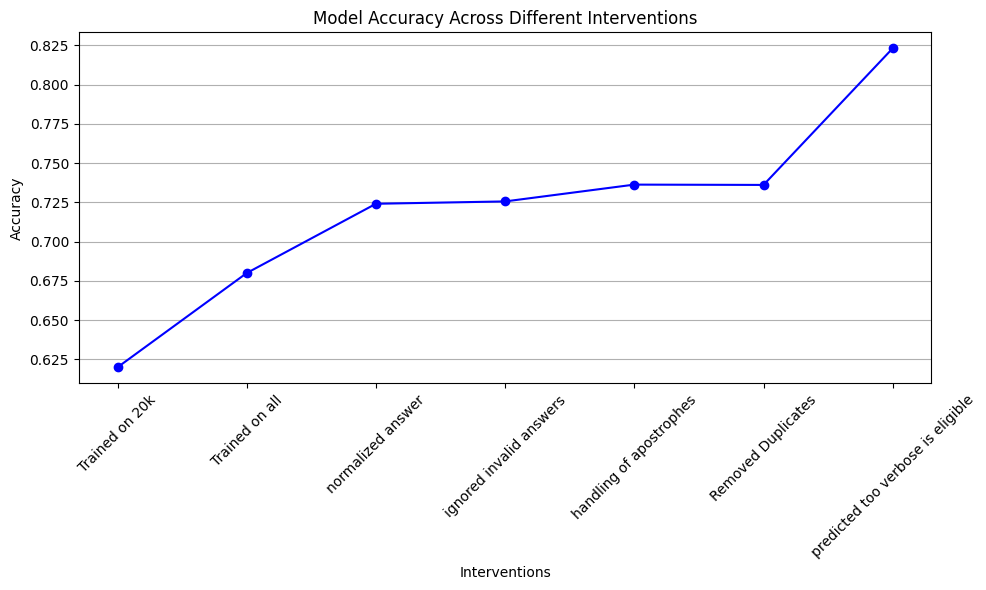

In [199]:
import matplotlib.pyplot as plt

# Sample accuracies from training interventions
accuracies = [0.62, 0.68, 0.7241, 0.7256, 0.7363, 0.7361, 0.8231]
intervention_labels = [
    "Trained on 20k",
    "Trained on all",
    "normalized answer",
    "ignored invalid answers",
    "handling of apostrophes",
    "Removed Duplicates",
    "predicted too verbose is eligible"
]

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(intervention_labels, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel("Interventions")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Across Different Interventions")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
